# Gossip Training of Deep Neural Networks for Image Classification

## Importing required modules

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from torchsummary import summary
import math
from collections import OrderedDict

from tqdm.auto import tqdm
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import copy
from sklearn.metrics import f1_score


seed = 2045
def manual_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    from torch.backends import cudnn
    cudnn.deterministic = True #type: ignore
    cudnn.benchmark = False # type: ignore

if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
 
print(f'Device is set to {DEVICE}')

Device is set to cuda


## Loading the dataset and pre-processing

In [2]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))

val_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5)]))
print(f"Size of the training set: {len(train_set)}")
print(f"Size of the test set: {len(val_set)}")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Size of the training set: 60000
Size of the test set: 10000


In [3]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
images, labels = next(iter(data_loader))
print(f"Image batch tensor dimensions: {images.shape}")

Image batch tensor dimensions: torch.Size([128, 1, 28, 28])


In [4]:
classes = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


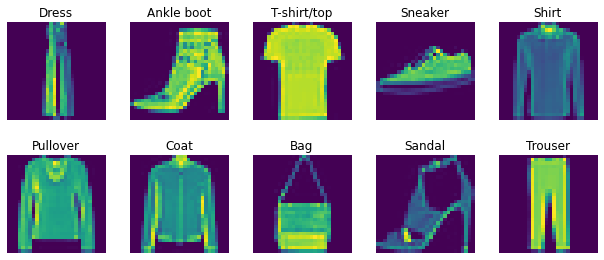

In [5]:
def imshow(img_array, labels, classes):
    figure, axs = plt.subplots(2, 5)
    count = 0
    for i in range(2):
      for j in range(5):
        imgTmp = torch.transpose(img_array[count],0,2)
        axs[i][j].imshow(torch.transpose(imgTmp, 0, 1).reshape((28,28)))
        axs[i][j].set_title(classes[int(labels[count])])
        axs[i][j].axis('off')
        count += 1
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    plt.show()

for i, data in enumerate(data_loader):
    images, labels = data[0].to("cpu"), data[1].to("cpu")
    break
distinct_labels = []
distinct_images = []
distinct_classes = []
for i in range(len(labels)):
    if int(labels[i]) not in distinct_classes:
        distinct_labels.append(int(labels[i]))
        distinct_images.append(images[i])
        distinct_classes.append(int(labels[i]))
    if len(distinct_classes) == 10:
        break
imshow(distinct_images, distinct_labels, classes)

## Model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        input_shape = (1, 28, 28)
        # CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=1)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2,padding=1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,padding=1)
        self.act2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size=2,padding=1)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(64*7*7, 512)
        self.dense2 = nn.Linear(512, 10)
        
        
        self.relu = nn.ReLU()
        self.softm = nn.Softmax(dim=1)


    def forward(self, x):
        # CNN forward
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxPool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxPool2(x)

        # Flatten
        x = self.flatten(x)
        # Dense and softmax forward
        x = self.dense1(x)
        #x = self.relu(x)
        x = self.dense2(x)
        x = self.softm(x)

        return x

# Utility Functions

In [7]:
def fit(model, train_loader, optimizer, criterion):
    model.train()
    train_len = len(train_loader)
    batch_size = train_loader.batch_size
    n_batches = math.ceil(train_len/batch_size)
    #print('Batch Size:', batch_size,'Number of Batches:', n_batches)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    #prog_bar = tqdm(enumerate(train_loader), total=int(train_len/batch_size))
    for i, data in enumerate(train_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [8]:
def train(hparams, train_loader):
    manual_seed(2045)
    model = CNN()
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
    train_loss = []
    train_accuracy = []
    start = time.time()
    for epoch in range(hparams['epochs']):
        print(f"Epoch {epoch+1} of {hparams['epochs']}")
        train_epoch_loss, train_epoch_accuracy = fit(
            model, train_loader, optimizer, criterion
        )

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

                
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")

    end = time.time()

    print(f"Training time: {(end-start)/60:.3f} minutes")
    return model, train_loss, train_accuracy

In [9]:
## Adopted from Stack Overflow

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)




    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [10]:
def detailed_analysis(model, n_classes, class_names, train_loader, test_loader, train_accuracy, train_loss):
    model.eval()

    ### Train
    loader = train_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_train = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_train[i] = class_corrects[i]/class_totals[i]

    cm_train = confusion_matrix(y_true, y_pred)
    y_true_train = copy.deepcopy(y_true)
    y_pred_train = copy.deepcopy(y_pred)
    

    ### Test
    loader = test_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_test = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_test[i] = class_corrects[i]/class_totals[i]
    cm_test = confusion_matrix(y_true, y_pred)
    y_true_test = copy.deepcopy(y_true)
    y_pred_test = copy.deepcopy(y_pred)

    fig, axs = plt.subplots(3, figsize=(30,20))
    axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_ylabel('Epoch')
    axs[0].set_xlabel('Loss')
    axs[0].legend()

    axs[1].plot(list(range(1,len(train_accuracy)+1)), train_accuracy, label='Train Acc')
    axs[1].set_title('Acc per Epoch')
    axs[1].set_ylabel('Epoch')
    axs[1].set_xlabel('Acc')
    axs[1].legend()

    x = np.arange(len(class_names))
    width = 0.2
    trains = axs[2].bar(x, class_accs_train, width, label='Train')
    tests = axs[2].bar(x + width, class_accs_test, width, label = 'Test')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy of Each Class')
    axs[2].set_xticks(x+width/2)
    axs[2].set_xticklabels(class_names)
    axs[2].legend()
    plt.show()

    return cm_train, cm_test, y_true_train, y_pred_train, y_true_test, y_pred_test

## Centralized Traininig

In [11]:
# Hyperparameters dict
hparams = {'batch_size': 128, 'epochs': 20}
train_loader = torch.utils.data.DataLoader(train_set, batch_size=hparams["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=hparams["batch_size"], shuffle=True)
model = CNN()
model.to(DEVICE)
summary(model, (1, 28, 28), batch_size=hparams['batch_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 32, 26, 26]             832
              ReLU-2          [128, 32, 26, 26]               0
         MaxPool2d-3          [128, 32, 14, 14]               0
            Conv2d-4          [128, 64, 12, 12]          51,264
              ReLU-5          [128, 64, 12, 12]               0
         MaxPool2d-6            [128, 64, 7, 7]               0
           Flatten-7                [128, 3136]               0
            Linear-8                 [128, 512]       1,606,144
            Linear-9                  [128, 10]           5,130
          Softmax-10                  [128, 10]               0
Total params: 1,663,370
Trainable params: 1,663,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 73.02
Params size (MB): 6.35
Estima

In [ ]:
model, train_loss, train_accuracy = train(hparams, train_loader)


Epoch 1 of 20
Train Loss: 1.7355, Train Acc: 73.18
Epoch 2 of 20
Train Loss: 1.6183, Train Acc: 84.43
Epoch 3 of 20
Train Loss: 1.5958, Train Acc: 86.62
Epoch 4 of 20
Train Loss: 1.5825, Train Acc: 87.92
Epoch 5 of 20
Train Loss: 1.5737, Train Acc: 88.75
Epoch 6 of 20
Train Loss: 1.5674, Train Acc: 89.42
Epoch 7 of 20
Train Loss: 1.5633, Train Acc: 89.78
Epoch 8 of 20
Train Loss: 1.5594, Train Acc: 90.23
Epoch 9 of 20
Train Loss: 1.5537, Train Acc: 90.72
Epoch 10 of 20
Train Loss: 1.5520, Train Acc: 90.93
Epoch 11 of 20
Train Loss: 1.5519, Train Acc: 90.94
Epoch 12 of 20
Train Loss: 1.5516, Train Acc: 90.92
Epoch 13 of 20
Train Loss: 1.5478, Train Acc: 91.34
Epoch 14 of 20
Train Loss: 1.5476, Train Acc: 91.33
Epoch 15 of 20
Train Loss: 1.5487, Train Acc: 91.20
Epoch 16 of 20
Train Loss: 1.5460, Train Acc: 91.46
Epoch 17 of 20
Train Loss: 1.5456, Train Acc: 91.55
Epoch 18 of 20
Train Loss: 1.5453, Train Acc: 91.56
Epoch 19 of 20
Train Loss: 1.5442, Train Acc: 91.67
Epoch 20 of 20
Train 

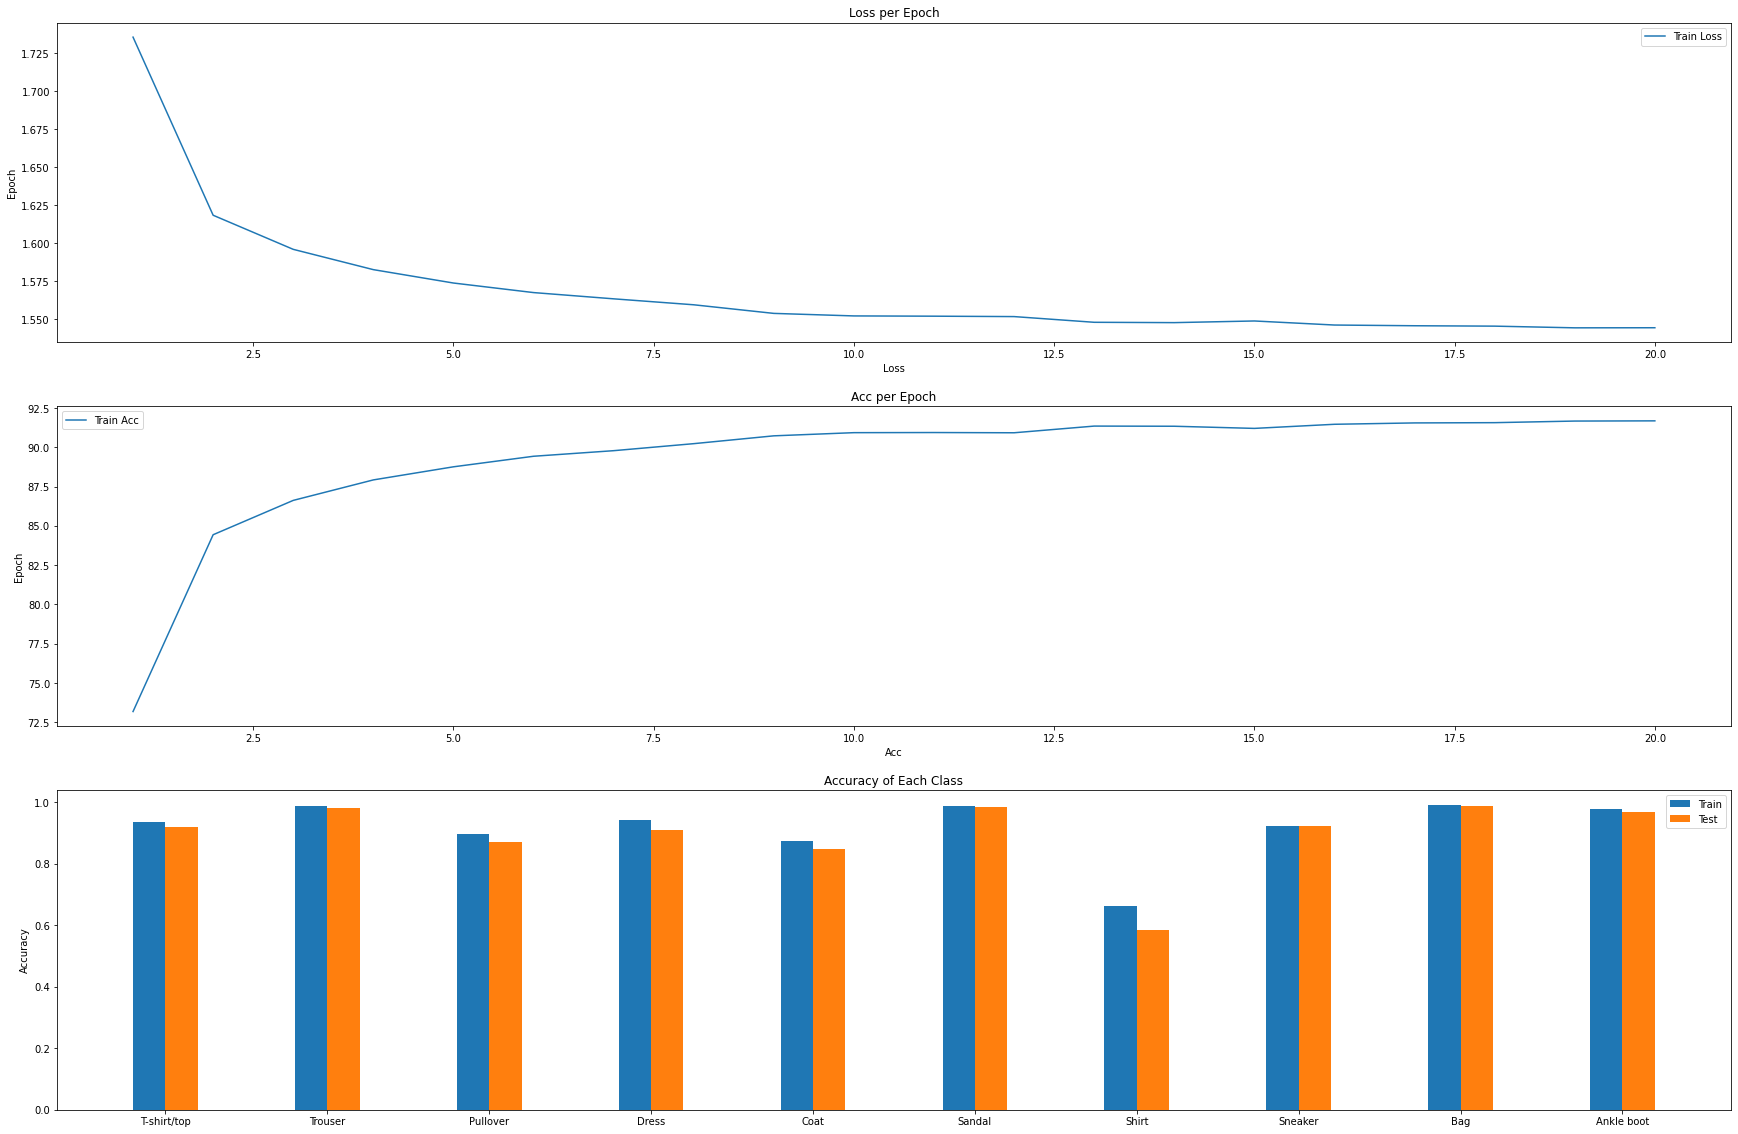

In [ ]:
cm_train, cm_test, y_true_train, y_pred_train, y_true_test, y_pred_test = detailed_analysis(model, 10, class_names,\
                                                                      train_loader, test_loader, train_accuracy, train_loss)

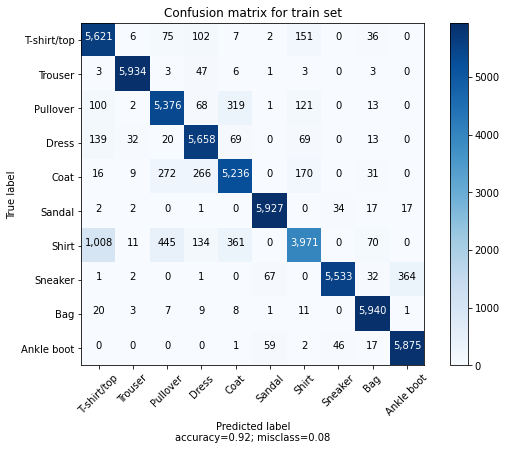

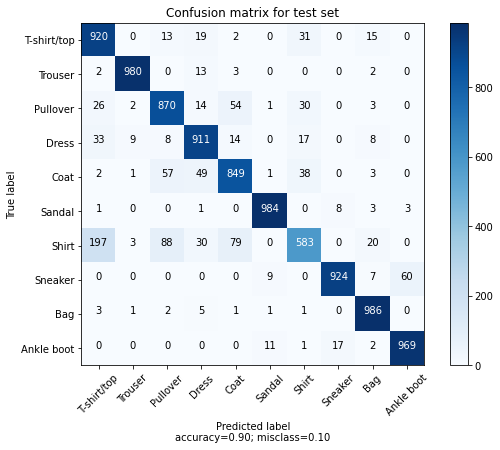

In [ ]:
plot_confusion_matrix(cm_train, class_names, title='Confusion matrix for train set', normalize=False)
print()
plot_confusion_matrix(cm_test, class_names, title='Confusion matrix for test set', normalize=False)

In [ ]:
print('Train set classification report')
print(classification_report(y_true_train, y_pred_train, target_names=class_names))

Train set classification report
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.94      0.87      6000
     Trouser       0.99      0.99      0.99      6000
    Pullover       0.87      0.90      0.88      6000
       Dress       0.90      0.94      0.92      6000
        Coat       0.87      0.87      0.87      6000
      Sandal       0.98      0.99      0.98      6000
       Shirt       0.88      0.66      0.76      6000
     Sneaker       0.99      0.92      0.95      6000
         Bag       0.96      0.99      0.98      6000
  Ankle boot       0.94      0.98      0.96      6000

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000



In [ ]:
print('Test set classification report')
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

Test set classification report
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.92      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.84      0.87      0.85      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.85      0.85      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.83      0.58      0.69      1000
     Sneaker       0.97      0.92      0.95      1000
         Bag       0.94      0.99      0.96      1000
  Ankle boot       0.94      0.97      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



# Dataset prepration (iid or non-iid)

In [11]:

manual_seed(seed)

train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))

val_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                        train=False,
                                        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5)]))


In [12]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]
        if self.transform:
            x = self.transform(x.numpy().astype(np.uint8))
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
        
def create_datasets(num_clients, iid):
    """Split the whole dataset in IID or non-IID manner for distributing to clients."""
    num_shards = 200
    training_dataset = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))


    num_categories = np.unique(training_dataset.targets).shape[0]
    
    if "ndarray" not in str(type(training_dataset.data)):
        training_dataset.data = np.asarray(training_dataset.data)
    if "list" not in str(type(training_dataset.targets)):
        training_dataset.targets = training_dataset.targets.tolist()
    
    # split dataset according to iid flag
    if iid:
        # shuffle data
        shuffled_indices = torch.randperm(len(training_dataset))
        training_inputs = training_dataset.data[shuffled_indices]
        training_labels = torch.Tensor(training_dataset.targets)[shuffled_indices]

        # partition data into num_clients
        split_size = len(training_dataset) // num_clients
        split_datasets = list(
            zip(
                torch.split(torch.Tensor(training_inputs), split_size),
                torch.split(torch.Tensor(training_labels), split_size)
            )
        )

        ## finalize bunches of local datasets
        local_datasets = [
            CustomTensorDataset(local_dataset, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))
            for local_dataset in split_datasets
            ]
        #local_datasets = [train_set for i in range(len(split_datasets))]
    else:
        # sort data by labels
        sorted_indices = torch.argsort(torch.Tensor(training_dataset.targets))
        training_inputs = training_dataset.data[sorted_indices]
        training_labels = torch.Tensor(training_dataset.targets)[sorted_indices]

        # partition data into shards first
        shard_size = len(training_dataset) // num_shards #300
        shard_inputs = list(torch.split(torch.Tensor(training_inputs), shard_size))
        shard_labels = list(torch.split(torch.Tensor(training_labels), shard_size))

        # sort the list to conveniently assign samples to each clients from at least two classes
        shard_inputs_sorted, shard_labels_sorted = [], []
        for i in range(num_shards // num_categories):
            for j in range(0, ((num_shards // num_categories) * num_categories), (num_shards // num_categories)):
                shard_inputs_sorted.append(shard_inputs[i + j])
                shard_labels_sorted.append(shard_labels[i + j])
                
        # finalize local datasets by assigning shards to each client
        shards_per_clients = num_shards // num_clients
        local_datasets = [
            CustomTensorDataset(
                (
                    torch.cat(shard_inputs_sorted[i:i + shards_per_clients]),
                    torch.cat(shard_labels_sorted[i:i + shards_per_clients]).long()
                ),
                transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
            ) 
            for i in range(0, len(shard_inputs_sorted), shards_per_clients)
        ]
    return local_datasets

# Worker Class

In [13]:
## Patially adopted from https://github.com/vaseline555/Federated-Averaging-PyTorch

class Worker(object):
    """
    Class for worker object
        id: Integer indicating worker's id.
        local_data: torch.utils.data.Dataset
        p: push message probability
        mode: "original", "stochastic", "doubly stochastic", "noisy", "periodic", "distributed data"
        number of workers: Integer
        noise rate: float
    """
    def __init__(self, worker_config, client_id, local_data, p, mode, noise=0):
        """Worker object is initialized"""
        self.id = client_id
        self.data = local_data
        self.device = DEVICE
        self.model = None
        self.worker_config = worker_config
        self.mode = mode
        self.p = p
        self.noise = noise
        self.num_workers = COMM_MATRIX.shape[0]
        self.constant = False
        if self.mode != "noisy":
            self.noise = 0
        if self.mode == "stochastic" or self.mode == "doubly stochastic" or self.mode == "periodic":
            self.constant = True

    def __len__(self):
        """Return a total size of the worker's local data."""
        return len(self.data)

    def setup(self):
        """Set up common configuration of each client; called by aggregator."""
        self.model = CNN()
        self.model.to(self.device)
        self.dataloader = DataLoader(self.data, batch_size=worker_config["batch_size"], shuffle=True)
        self.data_iter = iter(self.dataloader)
        self.criterion = self.worker_config["criterion"]
        self.optimizer = self.worker_config["optimizer"]
    
    def process_messages(self, queue):
        num = len(queue)
        for i in range(num):
            peer = queue.pop()
            alpha_i = COMM_MATRIX[self.id][self.id]
            alpha_j = COMM_MATRIX[self.id][peer]
            local_weights = copy.deepcopy(self.model.state_dict())
            peer_weights = copy.deepcopy(WORKERS[peer].model.state_dict())
            updated_weights = copy.deepcopy(self.model.state_dict())
            for key in self.model.state_dict().keys():
                if self.mode == "noisy":
                    w_noise = torch.randn_like(peer_weights[key])
                    updated_weights[key] = (alpha_j/(alpha_i+alpha_j))*(peer_weights[key] + self.noise*w_noise) + (alpha_i/(alpha_i+alpha_j))*local_weights[key]
                else:
                    updated_weights[key] = (alpha_j/(alpha_i+alpha_j))*peer_weights[key] + (alpha_i/(alpha_i+alpha_j))*local_weights[key]

            self.model.load_state_dict(updated_weights)
            if self.constant == False:
                COMM_MATRIX[self.id][self.id] += alpha_j
            
    def push_message(self, peer):
        if self.constant == False:
            COMM_MATRIX[self.id][peer] /= 2
        QUEUES[peer].append(self.id)

    def GoSGD(self):
        """Perform the GoSGD algorithm"""
        self.process_messages(QUEUES[self.id])
        self.model.train()
        self.model.to(self.device)
        try:
            data, labels = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.dataloader)
            data, labels = next(self.data_iter)
        data, labels = data.float().to(self.device), labels.long().to(self.device)
        optimizer = self.optimizer(self.model.parameters(), lr = self.worker_config["lr"], momentum = self.worker_config["momentum"])
        optimizer.zero_grad()
        outputs = self.model(data)
        loss = self.criterion()(outputs, labels)
        predicted = outputs.argmax(dim=1, keepdim=True)
        correct = predicted.eq(labels.view_as(predicted)).sum().item()
        accuracy = correct / len(labels)
        loss.backward()
        optimizer.step()

        if np.random.binomial(n=1, p=self.p):
            workers_list = [i for i in range(self.num_workers)]
            workers_list.remove(self.id)
            peer = np.random.choice(a=workers_list, p=[1/(self.num_workers-1) for i in range(self.num_workers-1)])
            self.push_message(peer)
        return loss.item(), accuracy

    def worker_evaluate(self):
        """Evaluate local model using local dataset (same as training set for convenience)."""
        self.model.eval()
        self.model.to(self.device)

        val_loss, correct = 0, 0
        with torch.no_grad():
            for data, labels in self.dataloader:
                data, labels = data.float().to(self.device), labels.long().to(self.device)
                outputs = self.model(data)
                val_loss += self.criterion()(outputs, labels).item()
                
                predicted = outputs.argmax(dim=1, keepdim=True)
                correct += predicted.eq(labels.view_as(predicted)).sum().item()
                
        val_loss = val_loss / len(self.dataloader)
        val_accuracy = correct / len(self.data)
        return val_loss, val_accuracy

# Aggregator Class

In [14]:
## Mostly adopted from https://github.com/vaseline555/Federated-Averaging-PyTorch

class Aggregator(object):
    """
    The controller and aggregator class for the process of gossip learning
    """
    def __init__(self, num_rounds, iid, worker_config, mode, p, noise=0):
        self._round = 0

        self.model = None
        
        self.seed = seed
        self.device = DEVICE

        self.iid = iid
        self.p = p
        self.num_rounds = num_rounds
        self.num_workers = int(COMM_MATRIX.shape[0])
        self.device = DEVICE
        self.worker_config = worker_config

        self.noise = noise
        self.mode = mode
        if self.mode != "noisy":
            self.noise = 0

        self.results = {"train loss": [], "train accuracy": [], "global train accuracy": [], "global train loss": [], "test loss": [], "test accuracy": []}

        
        print(f"Mode: {self.mode}")
        print(f"Dataset is iid: {self.iid}")

    def setup_workers(self, **init_kwargs):
        """Set up all configuration for gossip learning."""
        # valid only before the very first round
        assert self._round == 0

        # initialize weights of the model
        torch.manual_seed(self.seed)
        
        self.model = CNN()
        local_datasets = create_datasets(num_clients = self.num_workers, iid=self.iid)
        

        for k, dataset in tqdm(enumerate(local_datasets), leave=False):
            worker = Worker(self.worker_config, k, dataset, self.p, self.mode, self.noise)
            worker.setup()
            WORKERS.append(worker)

        self.criterion = self.worker_config["criterion"]

        print("Workers generated! Round 0...")
        # prepare train and val sets
        self.val_loader = DataLoader(val_set, batch_size=self.worker_config["batch_size"], shuffle=True)
        self.val_data = val_set
        self.train_loader = DataLoader(train_set, batch_size=self.worker_config["batch_size"], shuffle=True)
        self.train_data = train_set
        self.data_iter = iter(self.train_loader)

    def train_gossip(self):
        """Do gossip training."""
        for r in range(self.num_rounds):
            self._round = r + 1
            #print(len(WORKERS[0].data_iter))
            for batch_i in range(len(WORKERS[0].data_iter)):
                ##probs = np.ones((self.num_workers,))/self.num_workers
                ##worker_i = np.random.choice(a=self.num_workers, p=probs)
                loss_cum, acc_cum = 0, 0
                if self.mode == "periodic":
                    COMM_MATRIX = COMM_MATS[batch_i % (num_workers-1)]
                    #print(COMM_MATRIX)
                for worker_i in range(self.num_workers):
                    loss, acc = WORKERS[worker_i].GoSGD()
                    loss_cum += loss
                    acc_cum += acc
                l = loss_cum/self.num_workers
                a = acc_cum/self.num_workers
                self.results["train loss"].append(l)
                self.results["train accuracy"].append(a)

            self.build_aggregated_model()
            train_loss, train_accuracy, test_loss, test_accuracy = self.evaluate_aggregated_model()
            self.results['test loss'].append(test_loss)
            self.results['test accuracy'].append(test_accuracy)
            self.results['global train loss'].append(train_loss)
            self.results['global train accuracy'].append(train_accuracy)

            message = f"[Round: {str(self._round).zfill(4)}] Evaluate global model's performance...!\
                \n\t[Server] ...finished evaluation!\
                \n\t=> Global Train Loss: {train_loss:.4f}\
                \n\t=> Global Train Accuracy: {100. * train_accuracy:.2f}\
                \n\t=> Test Loss: {test_loss:.4f}\
                \n\t=> Test Accuracy: {100. * test_accuracy:.2f}%\n"
            print(message)

        return self.results

    def build_aggregated_model(self):
        """Average the updated parameters from each worker"""
        message = f"[Round: {str(self._round).zfill(4)}] Aggregate updated weights of {self.num_workers} workers...!"
        print(message); 

        averaged_weights = OrderedDict()
        for idx in range(self.num_workers):
            local_weights = WORKERS[idx].model.state_dict()
            for key in self.model.state_dict().keys():
                if idx == 0:
                    averaged_weights[key] = (1/self.num_workers) * local_weights[key]
                else:
                    averaged_weights[key] += (1/self.num_workers) * local_weights[key]

        self.model.load_state_dict(averaged_weights)

    def evaluate_aggregated_model(self):
        """Evaluate the aggregated model"""
        self.model.eval()
        self.model.to(self.device)

        train_loss, correct_train = 0, 0
        with torch.no_grad():
            for data, labels in self.train_loader:
                data, labels = data.float().to(self.device), labels.long().to(self.device)
                outputs = self.model(data)
                train_loss += self.criterion()(outputs, labels).item()
                
                predicted = outputs.argmax(dim=1, keepdim=True)
                correct_train += predicted.eq(labels.view_as(predicted)).sum().item()

        train_loss = train_loss / len(self.train_loader)
        train_accuracy = correct_train / len(self.train_data)

        self.model.eval()
        self.model.to(self.device)
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.float().to(self.device), labels.long().to(self.device)
                outputs = self.model(data)
                val_loss += self.criterion()(outputs, labels).item()
                
                predicted = outputs.argmax(dim=1, keepdim=True)
                correct_val += predicted.eq(labels.view_as(predicted)).sum().item()

                if self.device == "cuda": torch.cuda.empty_cache()

        val_loss = val_loss / len(self.val_loader)
        val_accuracy = correct_val / len(self.val_data)

        return train_loss, train_accuracy, val_loss, val_accuracy


## Original Gossip Learning

In [ ]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.ones((num_workers,num_workers))*(1/num_workers)
num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "original"
p=0.5
iid = True
# COMM_MATRIX = np.random.rand(num_workers,num_workers) + 0.1
# COMM_MATRIX = COMM_MATRIX / COMM_MATRIX.sum(1, keepdims=True)

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=0)

aggregator.setup_workers()

history_original = aggregator.train_gossip()

Mode: original
Dataset is iid: True


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3025                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3025                
	=> Test Accuracy: 10.00%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3024                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3024                
	=> Test Accuracy: 10.00%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3022                
	=> Global Train Accuracy: 10.13                
	=> Test Loss: 2.3022   

## Noisy Communications (Noise=0.1)

In [ ]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.ones((num_workers,num_workers))*(1/num_workers)
num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "noisy"
noise = 0.1
p=0.5
iid = True
# COMM_MATRIX = np.random.rand(num_workers,num_workers) + 0.1
# COMM_MATRIX = COMM_MATRIX / COMM_MATRIX.sum(1, keepdims=True)

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=noise)

aggregator.setup_workers()

history_noisy1 = aggregator.train_gossip()

Mode: noisy
Dataset is iid: True


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.1820                
	=> Global Train Accuracy: 36.60                
	=> Test Loss: 2.1825                
	=> Test Accuracy: 36.33%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.1013                
	=> Global Train Accuracy: 40.45                
	=> Test Loss: 2.1044                
	=> Test Accuracy: 40.23%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.0730                
	=> Global Train Accuracy: 42.23                
	=> Test Loss: 2.0765   

## Noisy Communications (Noise=0.5)

In [ ]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.ones((num_workers,num_workers))*(1/num_workers)
num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "noisy"
noise = 0.5
p=0.5
iid = True
# COMM_MATRIX = np.random.rand(num_workers,num_workers) + 0.1
# COMM_MATRIX = COMM_MATRIX / COMM_MATRIX.sum(1, keepdims=True)

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=noise)

aggregator.setup_workers()

history_noisy5 = aggregator.train_gossip()

Mode: noisy
Dataset is iid: True


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3532                
	=> Global Train Accuracy: 10.58                
	=> Test Loss: 2.3476                
	=> Test Accuracy: 10.99%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3442                
	=> Global Train Accuracy: 11.46                
	=> Test Loss: 2.3385                
	=> Test Accuracy: 12.09%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3406                
	=> Global Train Accuracy: 11.79                
	=> Test Loss: 2.3373   

## Constant Stochastic Matrix

In [ ]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.random.rand(num_workers,num_workers) + 0.1
COMM_MATRIX = COMM_MATRIX/COMM_MATRIX.sum(1, keepdims=True)
num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "stochastic"
p=0.5
iid = True

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=0)

aggregator.setup_workers()

history_stochastic = aggregator.train_gossip()

Mode: stochastic
Dataset is iid: True


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3024                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3024                
	=> Test Accuracy: 10.00%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3022                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3022                
	=> Test Accuracy: 10.00%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3020                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3020   

## Constant Doubly Stochastic Matrix

In [ ]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.ones((num_workers,num_workers))*(1/num_workers)

num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "doubly stochastic"
p=0.5
iid = True

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=0)

aggregator.setup_workers()

history_doubly_stochastic = aggregator.train_gossip()

Mode: doubly stochastic
Dataset is iid: True


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3025                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3025                
	=> Test Accuracy: 10.00%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3023                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3023                
	=> Test Accuracy: 10.00%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3021                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3021   

## Periodically Strongly Connected

In [15]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.ones((num_workers,num_workers))*(1/num_workers)
num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

COMM_MATS = []
for i in range (num_workers-1):
    mat = np.zeros((num_workers, num_workers))
    mat[i, i+1] = 1
    mat[i+1, i] = 1
    COMM_MATS.append(mat)

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "periodic"
comm_matrices = []

p=0.5
iid = True
# COMM_MATRIX = np.random.rand(num_workers,num_workers) + 0.1
# COMM_MATRIX = COMM_MATRIX / COMM_MATRIX.sum(1, keepdims=True)

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=0)

aggregator.setup_workers()

history_periodic = aggregator.train_gossip()

Mode: periodic
Dataset is iid: True


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3025                
	=> Global Train Accuracy: 16.47                
	=> Test Loss: 2.3025                
	=> Test Accuracy: 16.43%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3023                
	=> Global Train Accuracy: 22.92                
	=> Test Loss: 2.3023                
	=> Test Accuracy: 22.76%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3021                
	=> Global Train Accuracy: 27.05                
	=> Test Loss: 2.3021   

## Non-iid Data Distribution

In [ ]:
WORKERS = []
num_workers = 6
QUEUES = [[]]*num_workers
COMM_MATRIX = np.ones((num_workers,num_workers))*(1/num_workers)
num_rounds = 25
loc_batch_size = 128
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD
criterion = torch.nn.CrossEntropyLoss

worker_config = {}
worker_config["batch_size"] = loc_batch_size
worker_config["criterion"] = criterion
worker_config["optimizer"] = optimizer
worker_config["lr"] = lr
worker_config["momentum"] = momentum
mode = "non-iid"
p=0.5
iid = False
# COMM_MATRIX = np.random.rand(num_workers,num_workers) + 0.1
# COMM_MATRIX = COMM_MATRIX / COMM_MATRIX.sum(1, keepdims=True)

aggregator = Aggregator(num_rounds, iid, worker_config, mode, p, noise=0)

aggregator.setup_workers()

history_non_iid = aggregator.train_gossip()

Mode: non-iid
Dataset is iid: False


0it [00:00, ?it/s]

Workers generated! Round 0...
[Round: 0001] Aggregate updated weights of 6 workers...!
[Round: 0001] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3023                
	=> Global Train Accuracy: 10.00                
	=> Test Loss: 2.3023                
	=> Test Accuracy: 10.00%

[Round: 0002] Aggregate updated weights of 6 workers...!
[Round: 0002] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3019                
	=> Global Train Accuracy: 10.96                
	=> Test Loss: 2.3019                
	=> Test Accuracy: 11.15%

[Round: 0003] Aggregate updated weights of 6 workers...!
[Round: 0003] Evaluate global model's performance...!                
	[Server] ...finished evaluation!                
	=> Global Train Loss: 2.3012                
	=> Global Train Accuracy: 14.36                
	=> Test Loss: 2.3012   

# Post-processing

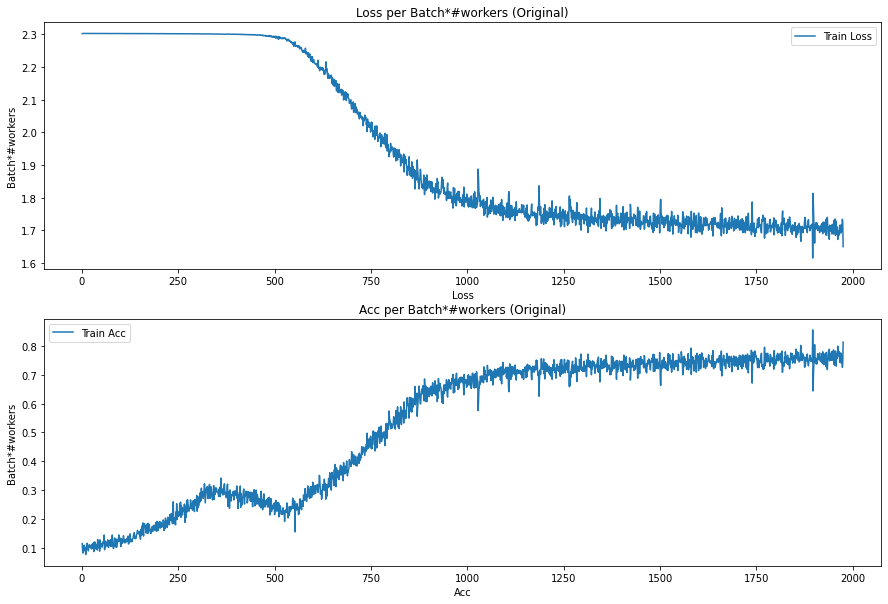

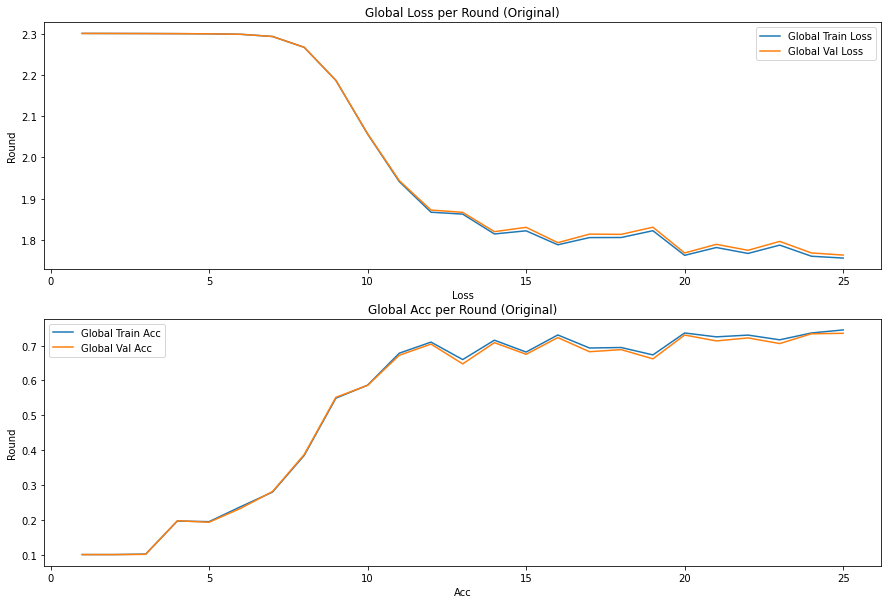

In [ ]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_original['train loss']
batch_train_acc = history_original["train accuracy"]
global_train_loss = history_original['global train loss']
global_train_acc = history_original['global train accuracy']
global_val_loss = history_original['test loss']
global_val_acc = history_original['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (Original)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (Original)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (Original)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (Original)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()



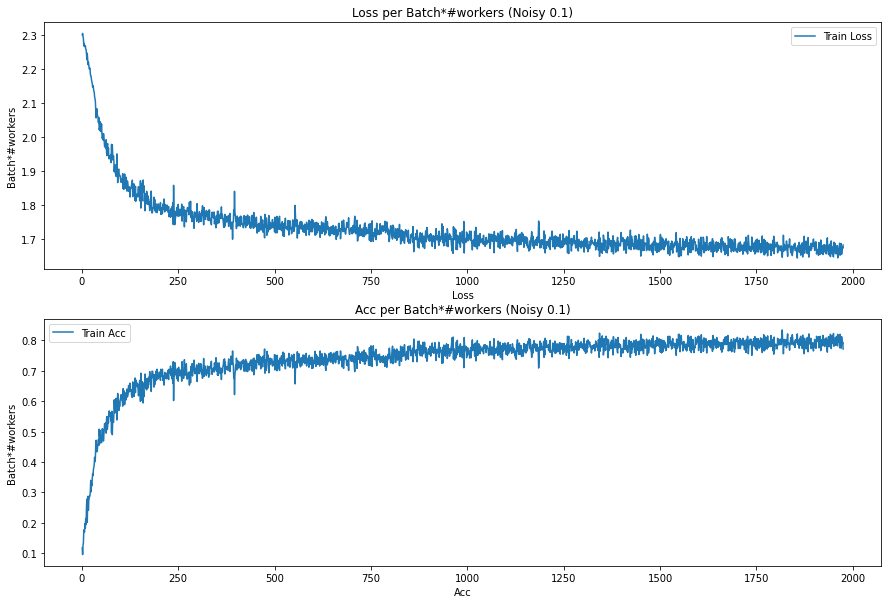

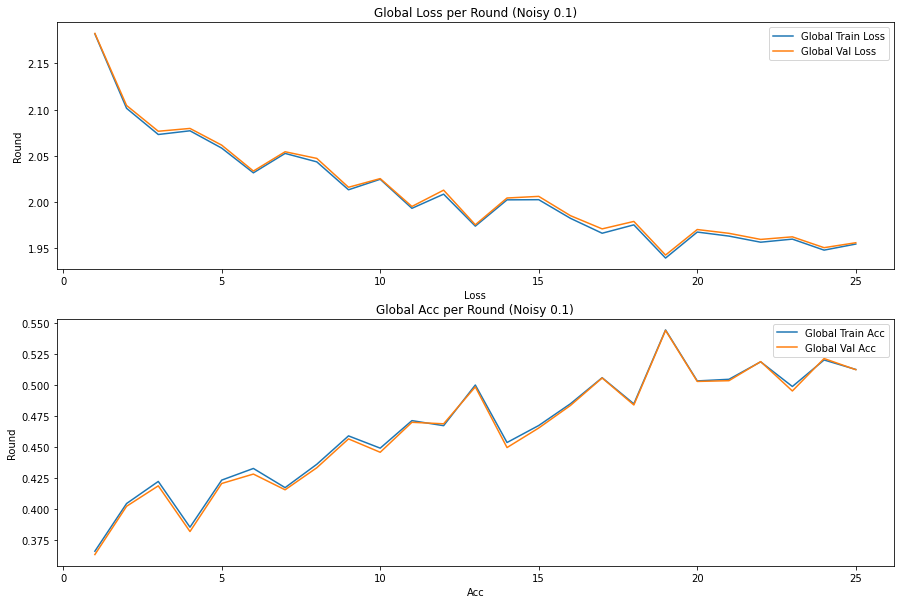

In [ ]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_noisy1['train loss']
batch_train_acc = history_noisy1["train accuracy"]
global_train_loss = history_noisy1['global train loss']
global_train_acc = history_noisy1['global train accuracy']
global_val_loss = history_noisy1['test loss']
global_val_acc = history_noisy1['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (Noisy 0.1)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (Noisy 0.1)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (Noisy 0.1)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (Noisy 0.1)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()



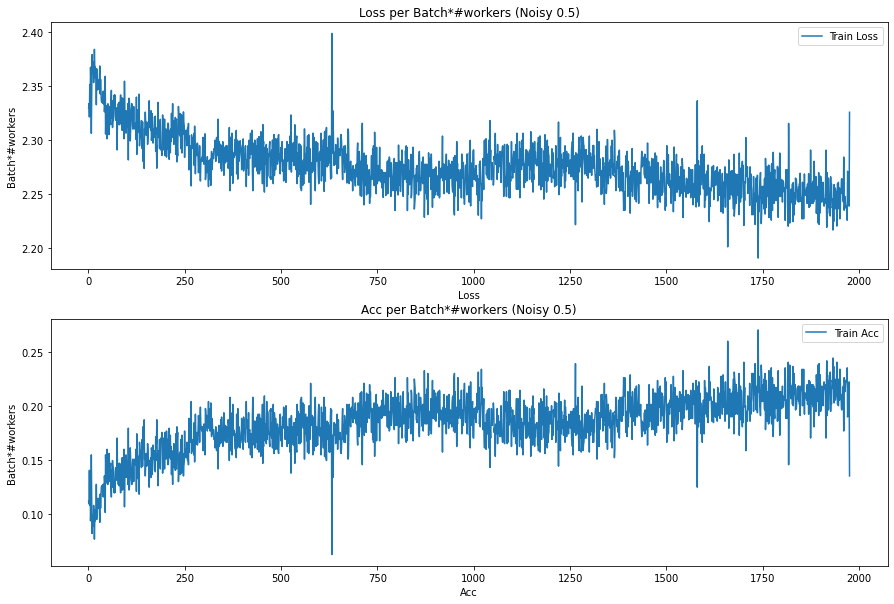

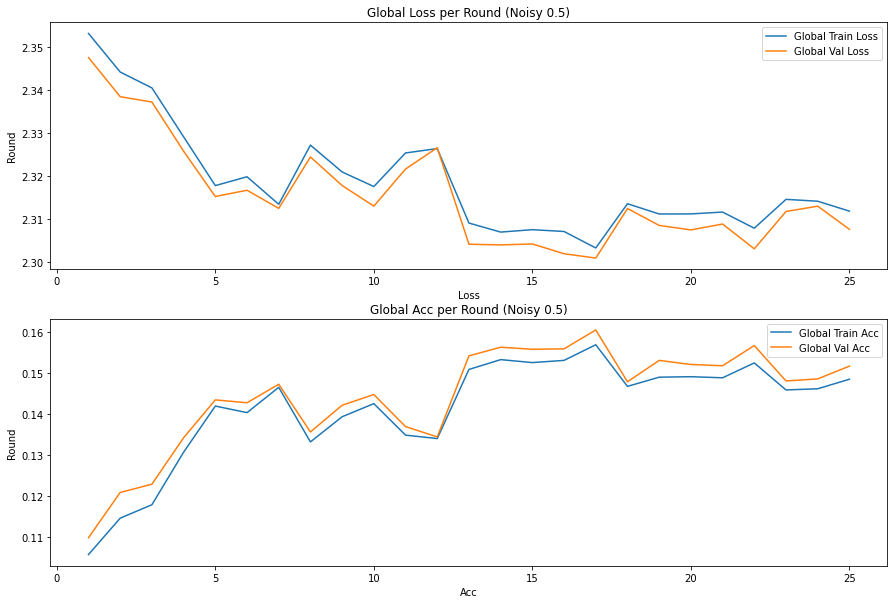

In [ ]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_noisy5['train loss']
batch_train_acc = history_noisy5["train accuracy"]
global_train_loss = history_noisy5['global train loss']
global_train_acc = history_noisy5['global train accuracy']
global_val_loss = history_noisy5['test loss']
global_val_acc = history_noisy5['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (Noisy 0.5)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (Noisy 0.5)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (Noisy 0.5)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (Noisy 0.5)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()



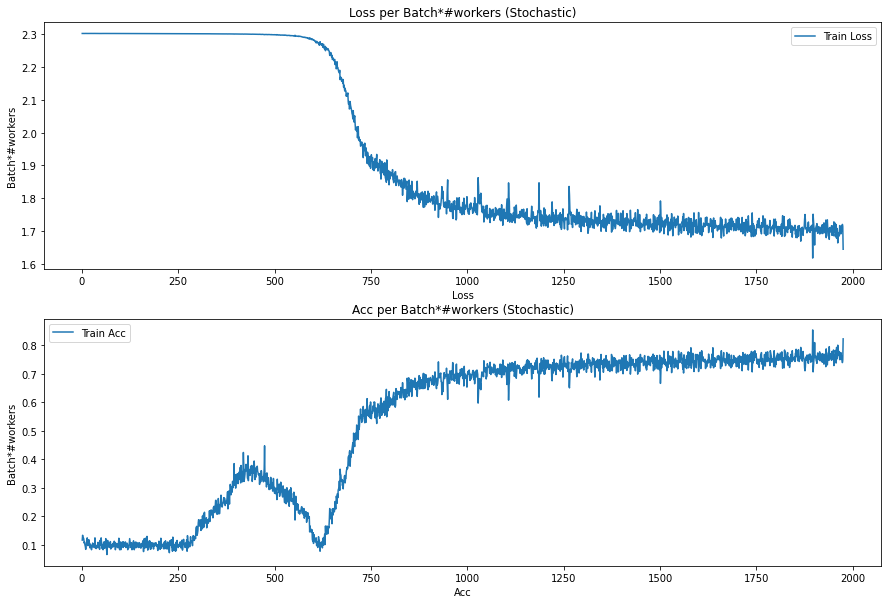

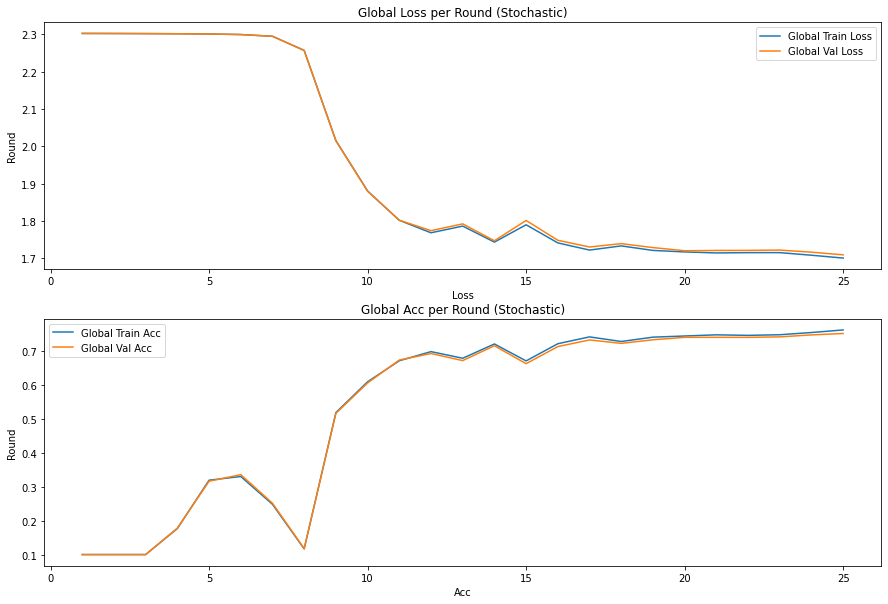

In [ ]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_stochastic['train loss']
batch_train_acc = history_stochastic["train accuracy"]
global_train_loss = history_stochastic['global train loss']
global_train_acc = history_stochastic['global train accuracy']
global_val_loss = history_stochastic['test loss']
global_val_acc = history_stochastic['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (Stochastic)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (Stochastic)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (Stochastic)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (Stochastic)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()



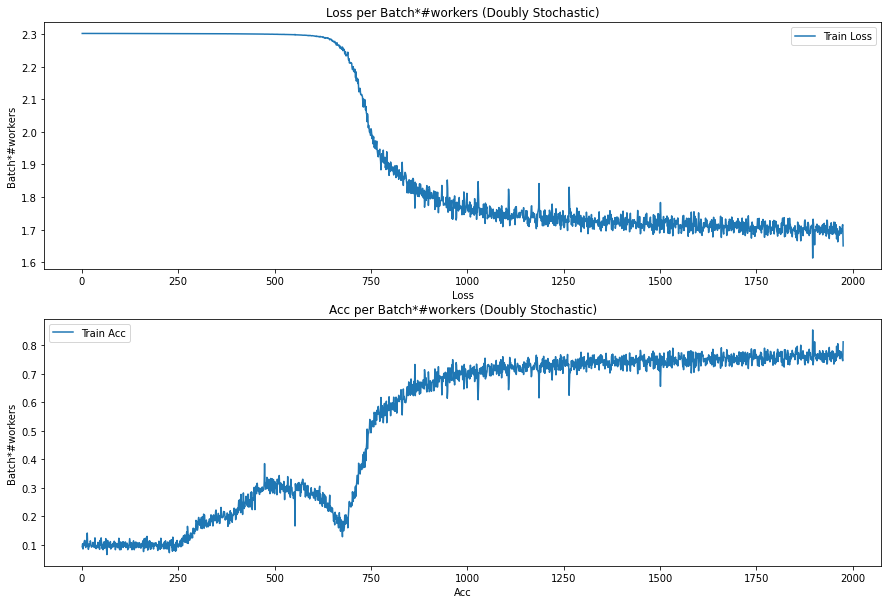

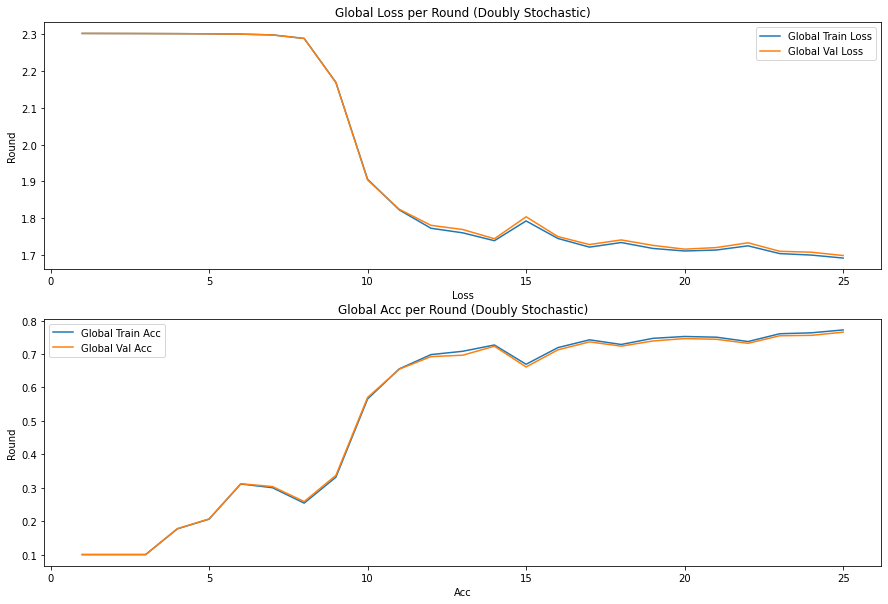

In [ ]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_doubly_stochastic['train loss']
batch_train_acc = history_doubly_stochastic["train accuracy"]
global_train_loss = history_doubly_stochastic['global train loss']
global_train_acc = history_doubly_stochastic['global train accuracy']
global_val_loss = history_doubly_stochastic['test loss']
global_val_acc = history_doubly_stochastic['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (Doubly Stochastic)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (Doubly Stochastic)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (Doubly Stochastic)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (Doubly Stochastic)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()



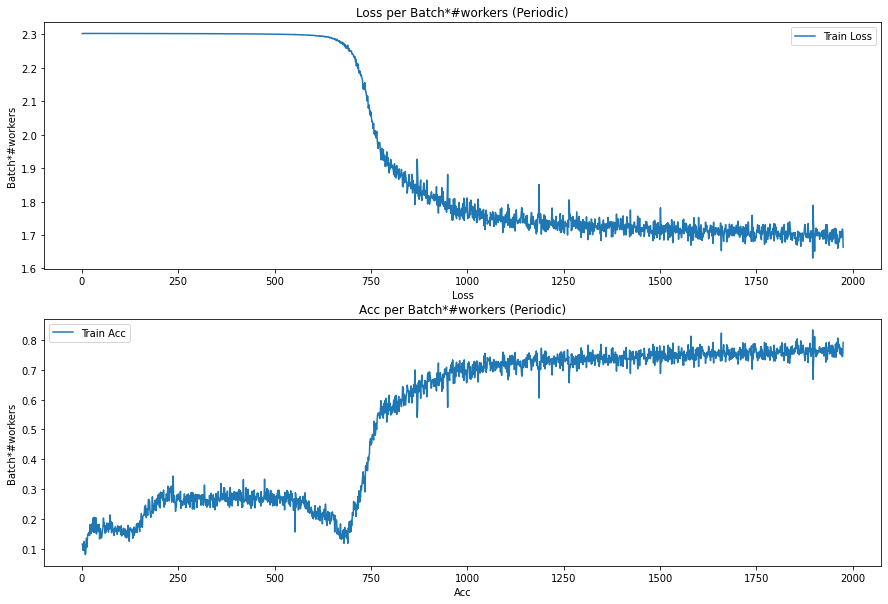

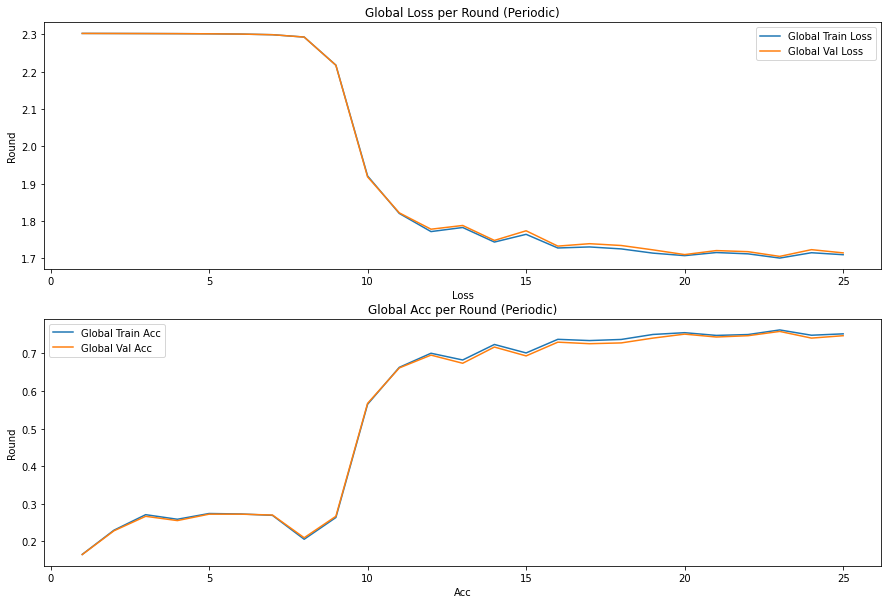

In [16]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_periodic['train loss']
batch_train_acc = history_periodic["train accuracy"]
global_train_loss = history_periodic['global train loss']
global_train_acc = history_periodic['global train accuracy']
global_val_loss = history_periodic['test loss']
global_val_acc = history_periodic['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (Periodic)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (Periodic)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (Periodic)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (Periodic)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()



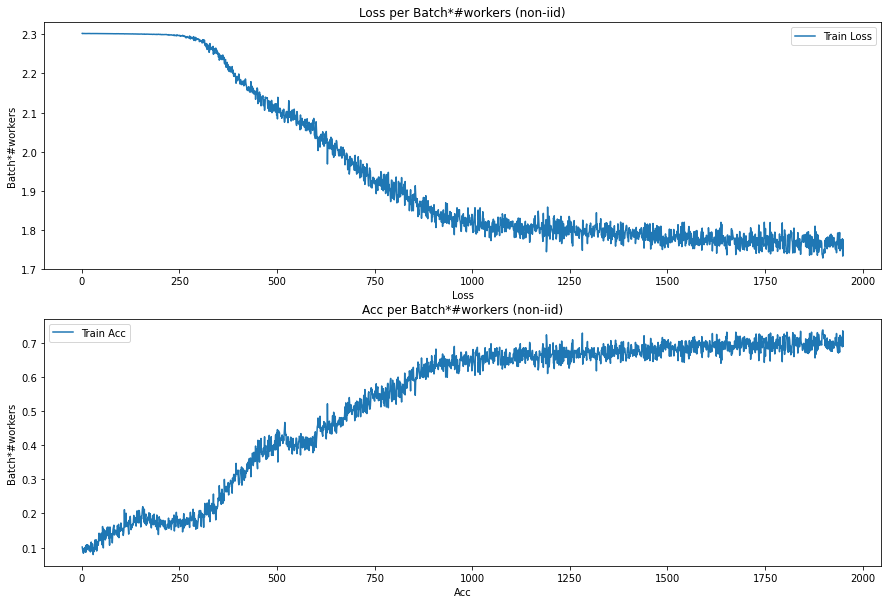

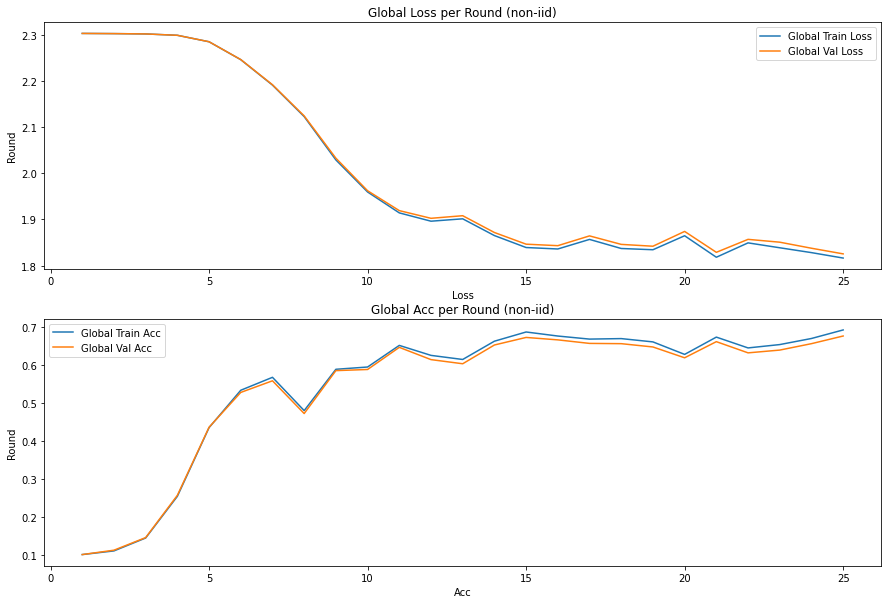

In [ ]:
fig, axs = plt.subplots(2, figsize=(15,10))

batch_train_loss = history_non_iid['train loss']
batch_train_acc = history_non_iid["train accuracy"]
global_train_loss = history_non_iid['global train loss']
global_train_acc = history_non_iid['global train accuracy']
global_val_loss = history_non_iid['test loss']
global_val_acc = history_non_iid['test accuracy']

axs[0].plot(list(range(1,len(batch_train_loss)+1)), batch_train_loss, label='Train Loss')
axs[0].set_title('Loss per Batch*#workers (non-iid)')
axs[0].set_ylabel('Batch*#workers')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(batch_train_acc)+1)), batch_train_acc, label='Train Acc')
axs[1].set_title('Acc per Batch*#workers (non-iid)')
axs[1].set_ylabel('Batch*#workers')
axs[1].set_xlabel('Acc')
axs[1].legend()

plt.show()

fig, axs = plt.subplots(2, figsize=(15,10))

axs[0].plot(list(range(1,len(global_train_loss)+1)), global_train_loss, label='Global Train Loss')
axs[0].plot(list(range(1,len(global_val_loss)+1)), global_val_loss, label='Global Val Loss')
axs[0].set_title('Global Loss per Round (non-iid)')
axs[0].set_ylabel('Round')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(global_train_acc)+1)), global_train_acc, label='Global Train Acc')
axs[1].plot(list(range(1,len(global_val_acc)+1)), global_val_acc, label='Global Val Acc')
axs[1].set_title('Global Acc per Round (non-iid)')
axs[1].set_ylabel('Round')
axs[1].set_xlabel('Acc')
axs[1].legend()


plt.show()

